In [ ]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from textblob import TextBlob

In [ ]:
# Load dataset
file_path = "/content/CompleteComments.xlsx"
df = pd.read_excel(file_path, sheet_name="Sheet1")
df.head()

,author,authorIsChannelOwner,cid,comments,commentsCount,hasCreatorHeart,pageUrl,publishedTimeText,replyCount,replyToCid,title,type,videoId,voteCount
0,@NirmalPillaiOriginal,False,Ugxz8h1sKO4m4Fic2rd4AaABAg,GUYS SUBTITLES HAVE BEEN ADDED! 😁 Please switc...,763,False,https://youtu.be/2wbedQasjMU?si=maPqEpf17ulCxorQ,3 months ago,9,NaN,FIRST MOVE | EP 02 with ‪‪@NirmalPillaiOrigina...,comment,2wbedQasjMU,989
1,@MaDx_007,False,Ugykz76SHXUmTrsE7qx4AaABAg,Abi and nirmal hitting on that multinlingual g...,763,False,https://youtu.be/2wbedQasjMU?si=maPqEpf17ulCxorQ,4 months ago,5,NaN,FIRST MOVE | EP 02 with ‪‪@NirmalPillaiOrigina...,comment,2wbedQasjMU,1700
2,@anjalidilish6495,False,Ugwh-l__P374iDhDhMh4AaABAg,"props to revathi bro, like she carried that wh...",763,False,https://youtu.be/2wbedQasjMU?si=maPqEpf17ulCxorQ,3 months ago,1,NaN,FIRST MOVE | EP 02 with ‪‪@NirmalPillaiOrigina...,comment,2wbedQasjMU,303
3,@vishnumtm,False,Ugxb4dqwyIzJi3updM14AaABAg,Best date - Tessa and Adringya 😊,763,False,https://youtu.be/2wbedQasjMU?si=maPqEpf17ulCxorQ,3 months ago,1,NaN,FIRST MOVE | EP 02 with ‪‪@NirmalPillaiOrigina...,comment,2wbedQasjMU,442
4,@nishanthchary6616,False,UgxJW4nP-87vw6korBN4AaABAg,a small suggestion and a request pleaseee keep...,763,False,https://youtu.be/2wbedQasjMU?si=maPqEpf17ulCxorQ,4 months ago,2,NaN,FIRST MOVE | EP 02 with ‪‪@NirmalPillaiOrigina...,comment,2wbedQasjMU,352


In [ ]:
df = df.drop(['author', 'authorIsChannelOwner','cid','commentsCount','hasCreatorHeart','pageUrl','publishedTimeText','replyCount','replyToCid','title','type','videoId','voteCount'], axis=1)

In [ ]:
df.head()

,comments
0,GUYS SUBTITLES HAVE BEEN ADDED! 😁 Please switc...
1,Abi and nirmal hitting on that multinlingual g...
2,"props to revathi bro, like she carried that wh..."
3,Best date - Tessa and Adringya 😊
4,a small suggestion and a request pleaseee keep...


In [ ]:
# Display basic statistics about the dataset
print("Total comments in dataset:", len(df))
print("Maximum length of any comment (in characters):", df["comments"].apply(lambda x: len(str(x))).max())
print("Minimum number of words in a comment:", df["comments"].apply(lambda x: len(str(x).split())).max())

Total comments in dataset: 5320
Maximum length of any comment (in characters): 3271
Minimum number of words in a comment: 588


In [ ]:
chunk_size = 5000
for i in range(0, len(df), chunk_size):
    df_chunk = df.iloc[i:i+chunk_size]
    # Process df_chunk independently

In [ ]:
df


,comments
0,GUYS SUBTITLES HAVE BEEN ADDED! 😁 Please switc...
1,Abi and nirmal hitting on that multinlingual g...
2,"props to revathi bro, like she carried that wh..."
3,Best date - Tessa and Adringya 😊
4,a small suggestion and a request pleaseee keep...
...,...
5315,உங்களுடைய பெரும்பாலான யூடியூப் வீடியோக்கள் (அத...
5316,நீங்க உங்க தாய்மொழியை மதிக்கலன்னு நினைக்கிறேன்...
5317,ஏய். உனக்கு புத்தி இல்லையா. உன் வீடியோக்களில் ...
5318,"If u call good looking girls on stage, possibl..."


In [ ]:
# Ensure 'comments' column exists
if "comments" not in df.columns:
    raise ValueError("Dataset does not contain a 'comments' column.")

In [ ]:
# Drop missing values and convert to string
df = df.dropna(subset=["comments"])
df["comments"] = df["comments"].astype(str)
# Text Preprocessing Function
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    stopwords = set([
        "i", "me", "my", "myself", "we", "our", "ours", "ourselves", "you", "your", "yours",
        "yourself", "yourselves", "he", "him", "his", "himself", "she", "her", "hers",
        "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves",
        "what", "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are",
        "was", "were", "be", "been", "being", "have", "has", "had", "having", "do", "does",
        "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until",
        "while", "of", "at", "by", "for", "with", "about", "against", "between", "into",
        "through", "during", "before", "after", "above", "below", "to", "from", "up", "down",
        "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here",
        "there", "when", "where", "why", "how", "all", "any", "both", "each", "few", "more",
        "most", "other", "some", "such", "no", "nor", "not", "only", "own", "same", "so",
        "than", "too", "very", "s", "t", "can", "will", "just", "don", "should", "now"
    ])
    text = " ".join(word for word in text.split() if word not in stopwords)
    return text

df["comments"] = df["comments"].apply(preprocess_text)

In [ ]:
df

,comments
0,guys subtitles added please switch cc english ...
1,abi nirmal hitting multinlingual girlie
2,props revathi bro like carried whole conversat...
3,best date tessa adringya
4,small suggestion request pleaseee keep subtitl...
...,...
5315,
5316,
5317,
5318,u call good looking girls stage possiblity views


In [ ]:
# Assign sentiment labels using TextBlob if not available
def get_sentiment(text):
    analysis = TextBlob(text)
    if analysis.sentiment.polarity > 0:
        return "positive"
    elif analysis.sentiment.polarity < 0:
        return "negative"
    else:
        return "neutral"

if "sentiment" not in df.columns:
    df["sentiment"] = df["comments"].apply(get_sentiment)

In [ ]:
df


,comments,sentiment
0,guys subtitles added please switch cc english ...,neutral
1,abi nirmal hitting multinlingual girlie,neutral
2,props revathi bro like carried whole conversat...,positive
3,best date tessa adringya,positive
4,small suggestion request pleaseee keep subtitl...,positive
...,...,...
5315,,neutral
5316,,neutral
5317,,neutral
5318,u call good looking girls stage possiblity views,positive


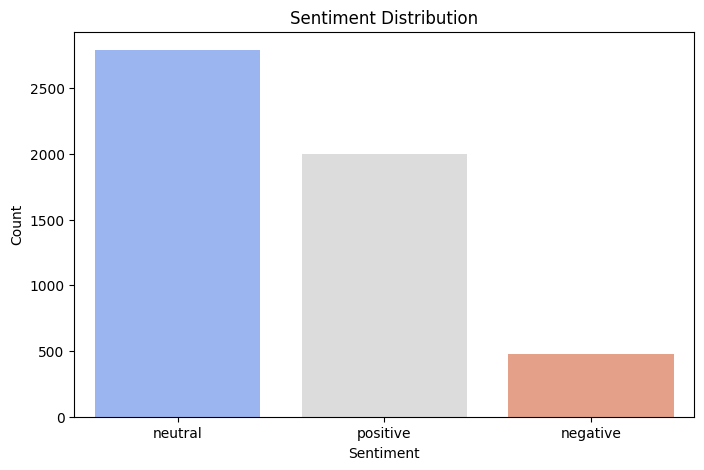

In [ ]:
# Visualizing Sentiment Distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=df["sentiment"], palette="coolwarm")
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()

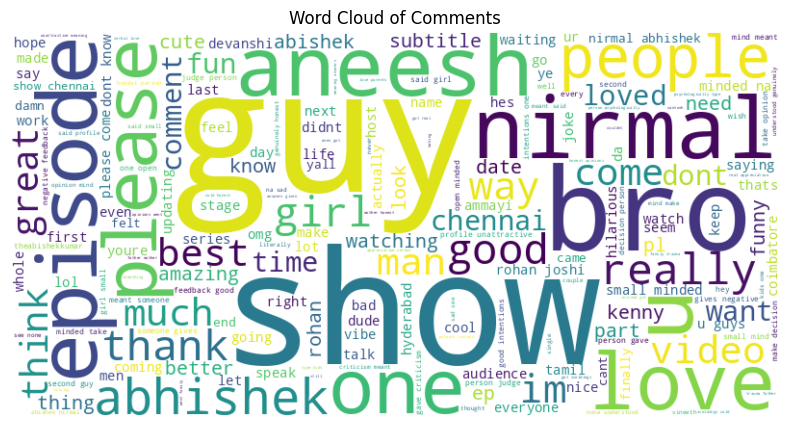

In [ ]:
# Generate Word Cloud for Most Frequent Words
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(df["comments"]))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Comments")
plt.show()

In [ ]:
# Splitting dataset into training, testing, and validation sets
X = df["comments"]
y = df["sentiment"]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [ ]:
X

,comments
0,guys subtitles added please switch cc english ...
1,abi nirmal hitting multinlingual girlie
2,props revathi bro like carried whole conversat...
3,best date tessa adringya
4,small suggestion request pleaseee keep subtitl...
...,...
5315,
5316,
5317,
5318,u call good looking girls stage possiblity views


In [ ]:
y

,sentiment
0,neutral
1,neutral
2,positive
3,positive
4,positive
...,...
5315,neutral
5316,neutral
5317,neutral
5318,positive


In [ ]:
# TF-IDF Vectorization
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)
X_val_tfidf = vectorizer.transform(X_val)

In [ ]:
vectorizer = TfidfVectorizer(max_features=2000)  # instead of 5000

In [ ]:
vectorizer

TfidfVectorizer(max_features=2000)

In [ ]:
# Training the Model
model = LogisticRegression(max_iter=200)
model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=200)

In [ ]:
# Prediction
y_pred = model.predict(X_test_tfidf)

In [ ]:
# Model Performance Metrics
accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)
print("Classification Report:\n", classification_report(y_test, y_pred))

Model Accuracy: 0.8719898605830165
Classification Report:
               precision    recall  f1-score   support

    negative       0.96      0.29      0.44        84
     neutral       0.86      0.98      0.91       417
    positive       0.89      0.89      0.89       288

    accuracy                           0.87       789
   macro avg       0.90      0.72      0.75       789
weighted avg       0.88      0.87      0.85       789



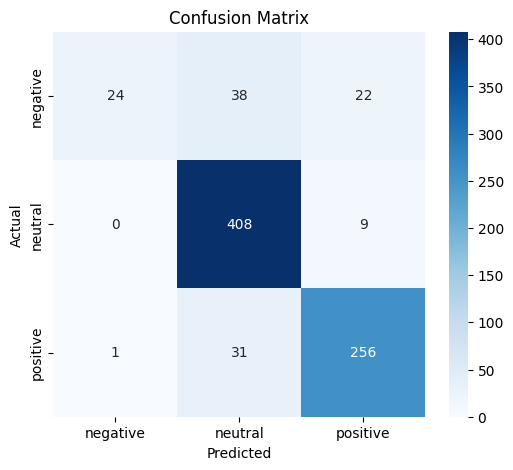

In [ ]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Show comments with their predicted sentiment
df_results = pd.DataFrame({"comments": X_test, "predicted_sentiment": y_pred})

In [ ]:
df_results

,comments,predicted_sentiment
2956,gurgaon plspls boyfriend saying coimbatore,neutral
289,bring kochin brooh,neutral
4651,wheres front row gang,neutral
627,least provide proper subtitles north indian pe...,neutral
4131,actually good old episodes,positive
...,...,...
2614,4022 well aged like wine,positive
2421,least provide proper subtitles north indian pe...,neutral
2292,namma kudla da ponnu raisiyer,neutral
3646,hate hosur aneesh,negative


In [ ]:
# Display first few results
print("\n🔹 Sample Sentiment Predictions:\n")
print(df_results.head(20))


🔹 Sample Sentiment Predictions:

                                               comments predicted_sentiment
2956         gurgaon plspls boyfriend saying coimbatore             neutral
289                                  bring kochin brooh             neutral
4651                              wheres front row gang             neutral
627   least provide proper subtitles north indian pe...             neutral
4131                         actually good old episodes            positive
3588                                 show laughing riot             neutral
3890  hands best episode date kenny killed paavam un...            positive
2303                  come chennai give tickets well tt             neutral
73               abishek nirmal indian ant dec duo podu             neutral
1096  nithyarahul1265 firstly comes stage voluntaril...            positive
4016                                        boards wait             neutral
2932           dai boys epo chennai la show nadathuvig

In [ ]:

import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

# Preprocessing function
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text).lower()
    stopwords = set([
        "i","me","my","myself","we","our","ours","ourselves","you","your","yours",
        "yourself","yourselves","he","him","his","himself","she","her","hers","herself",
        "it","its","itself","they","them","their","theirs","themselves","what","which",
        "who","whom","this","that","these","those","am","is","are","was","were","be",
        "been","being","have","has","had","having","do","does","did","doing","a","an",
        "the","and","but","if","or","because","as","until","while","of","at","by","for",
        "with","about","against","between","into","through","during","before","after",
        "above","below","to","from","up","down","in","out","on","off","over","under",
        "again","further","then","once","here","there","when","where","why","how","all",
        "any","both","each","few","more","most","other","some","such","no","nor","not",
        "only","own","same","so","than","too","very","s","t","can","will","just","don",
        "should","now"
    ])
    return " ".join(w for w in text.split() if w not in stopwords)

train_comments = df['comments']  # your list of comments
train_labels = df['sentiment']    # your list of corresponding labels

preprocessed = [preprocess_text(c) for c in train_comments]
vectorizer = TfidfVectorizer()
X_train = vectorizer.fit_transform(preprocessed)

model = LogisticRegression()
model.fit(X_train, train_labels)

def predict_sentiment(comment):
    preprocessed = preprocess_text(comment)
    vectorized = vectorizer.transform([preprocessed])
    return model.predict(vectorized)[0]

new_comment = input("Enter a comment to analyze sentiment: ")
predicted_sentiment = predict_sentiment(new_comment)
print(f"The predicted sentiment is: {predicted_sentiment}")

Enter a comment to analyze sentiment: good morning
The predicted sentiment is: positive


In [ ]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt
import librosa
import librosa.display
from IPython.display import Audio

import torchaudio
import torch
from torch.utils.data import Dataset,DataLoader
from transformers import Wav2Vec2Model,Wav2Vec2Processor,Trainer,TrainingArguments,Wav2Vec2ForSequenceClassification

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
paths=[]
labels=[]
for dirname, _, filenames in os.walk('/content/drive/MyDrive/speech dataset'):
  for filename in filenames:
    paths.append(os.path.join(dirname,filename))
    label=filename.split('_')[-1]
    label=label.split('.')[0]
    labels.append(label.lower())
  if len(paths)==2800:
    break
  print('dataset is loaded')

dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded
dataset is loaded


In [ ]:
len(paths)

1887

In [ ]:
paths[:5]

['/content/drive/MyDrive/speech dataset/TESS Toronto emotional speech set data/YAF_disgust/YAF_base_disgust.wav',
 '/content/drive/MyDrive/speech dataset/TESS Toronto emotional speech set data/YAF_disgust/YAF_bath_disgust.wav',
 '/content/drive/MyDrive/speech dataset/TESS Toronto emotional speech set data/YAF_disgust/YAF_back_disgust.wav',
 '/content/drive/MyDrive/speech dataset/TESS Toronto emotional speech set data/YAF_disgust/YAF_beg_disgust.wav',
 '/content/drive/MyDrive/speech dataset/TESS Toronto emotional speech set data/YAF_disgust/YAF_boat_disgust.wav']

In [ ]:
!kaggle datasets download -d ejlok1/toronto-emotional-speech-set-tess

Traceback (most recent call last):
  File "/usr/local/bin/kaggle", line 10, in <module>
    sys.exit(main())
             ^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/cli.py", line 68, in main
    out = args.func(**command_args)
          ^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 1741, in dataset_download_cli
    with self.build_kaggle_client() as kaggle:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/kaggle/api/kaggle_api_extended.py", line 688, in build_kaggle_client
    username=self.config_values['username'],
             ~~~~~~~~~~~~~~~~~~^^^^^^^^^^^^
KeyError: 'username'


In [ ]:
labels[:5]

['disgust', 'disgust', 'disgust', 'disgust', 'disgust']

In [ ]:
df=pd.DataFrame()
df['audio_paths']=paths
df['labels']=labels
df.head()


,audio_paths,labels
0,/content/drive/MyDrive/speech dataset/TESS Tor...,disgust
1,/content/drive/MyDrive/speech dataset/TESS Tor...,disgust
2,/content/drive/MyDrive/speech dataset/TESS Tor...,disgust
3,/content/drive/MyDrive/speech dataset/TESS Tor...,disgust
4,/content/drive/MyDrive/speech dataset/TESS Tor...,disgust


In [ ]:
df['labels'].value_counts()

,count
labels,
ps,400
sad,400
neutral,287
happy,200
disgust,200
angry,200
fear,200


<Axes: xlabel='labels', ylabel='count'>

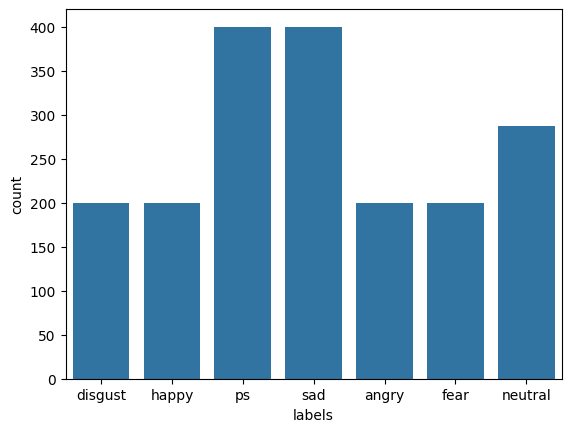

In [ ]:
sns.countplot(data=df,x='labels')

In [ ]:
def waveplot(data,sr,emotion):
  plt.figure(figsize=(10,4))
  plt.title(emotion,size=20)
  librosa.display.waveshow(data,sr=sr)
  plt.show()

def spectogram(data,sr,emotion):
  x=librosa.stft(data)
  xdb=librosa.amplitude_to_db(abs(x))
  plt.figure(figsize=(11,4))
  plt.title(emotion,size=20)
  librosa.display.specshow(xdb,sr=sr,x_axis='time',y_axis='hz')
  plt.colorbar()

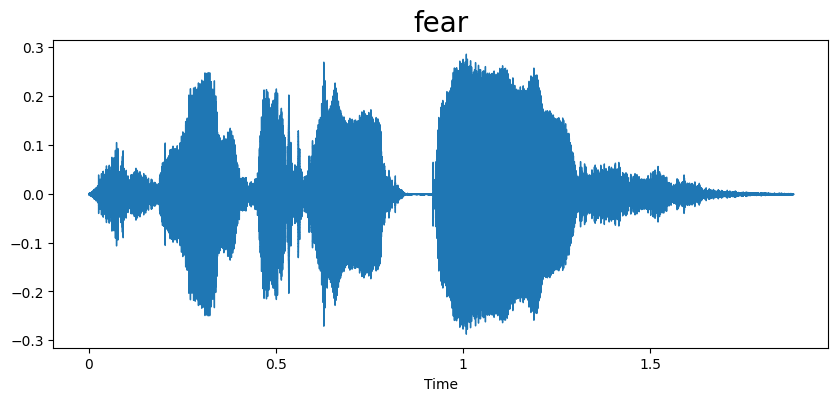

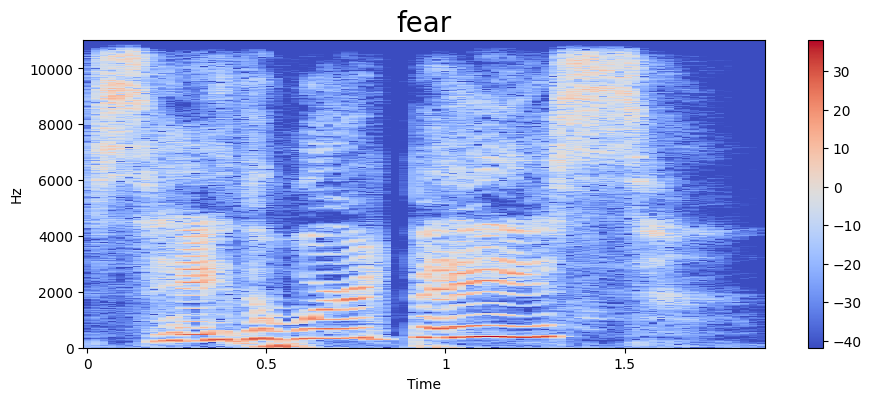

In [ ]:
emotion='fear'
path=np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate=librosa.load(path)
waveplot(data, sampling_rate,emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

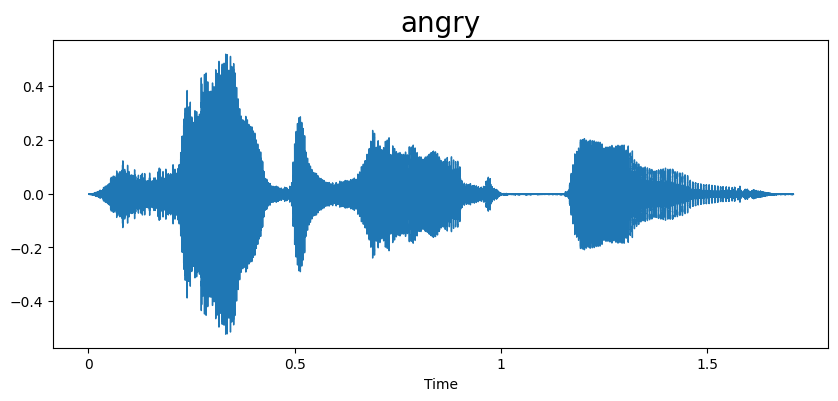

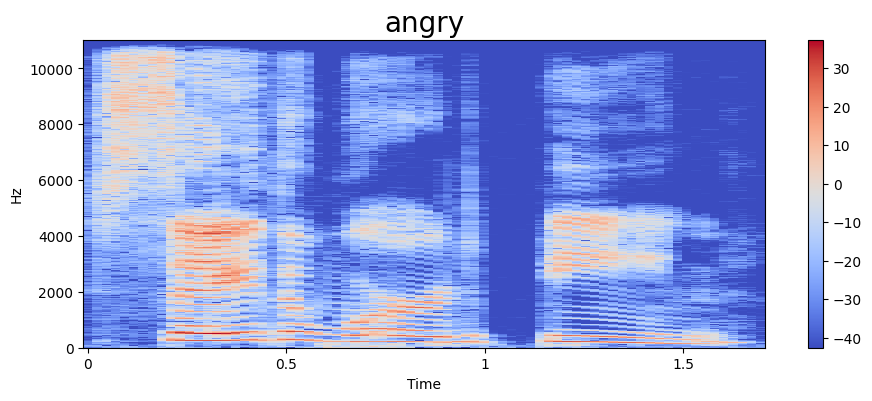

In [ ]:
emotion='angry'
path=np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate=librosa.load(path)
waveplot(data, sampling_rate,emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

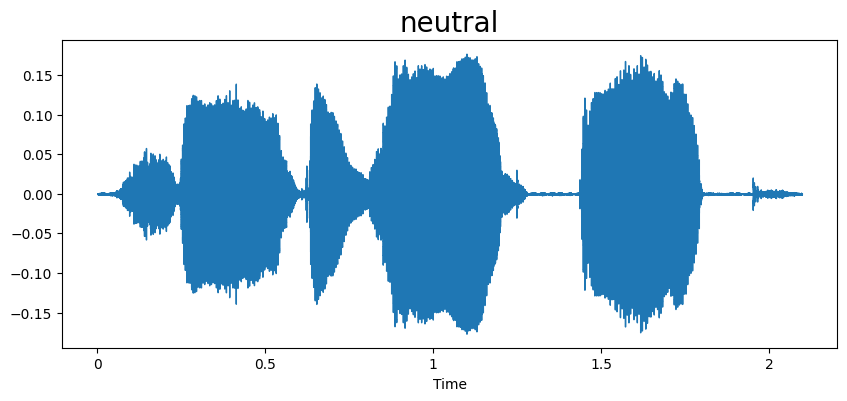

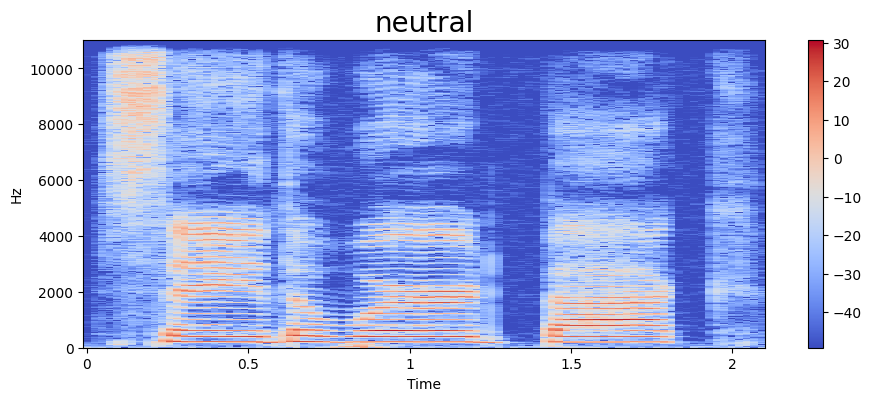

In [ ]:
emotion='neutral'
path=np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate=librosa.load(path)
waveplot(data, sampling_rate,emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

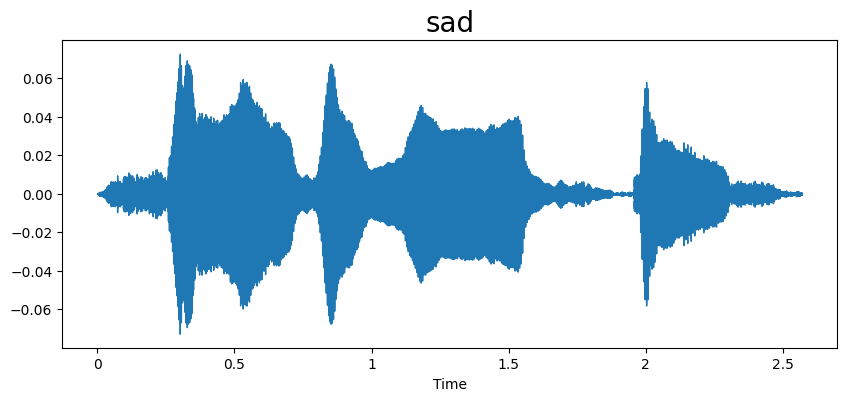

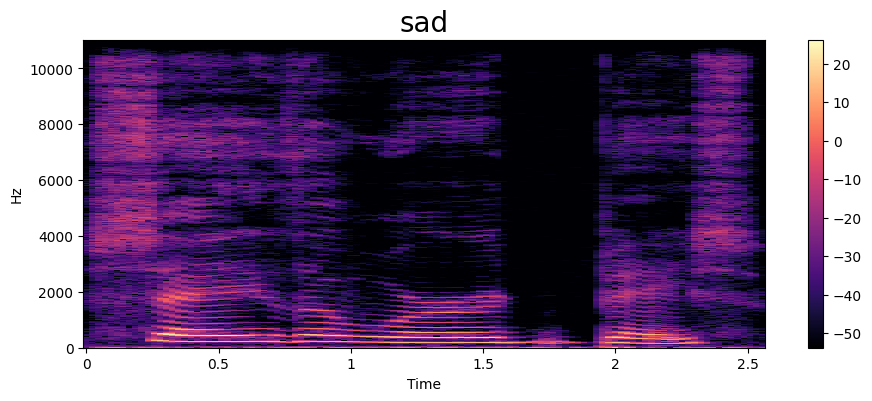

In [ ]:
emotion='sad'
path=np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate=librosa.load(path)
waveplot(data, sampling_rate,emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)

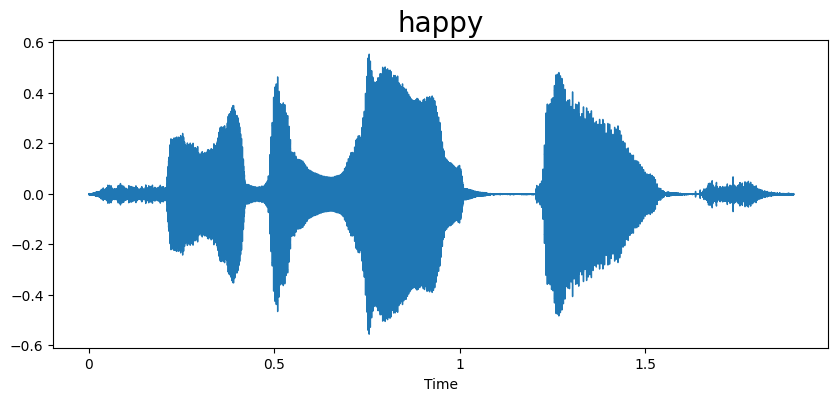

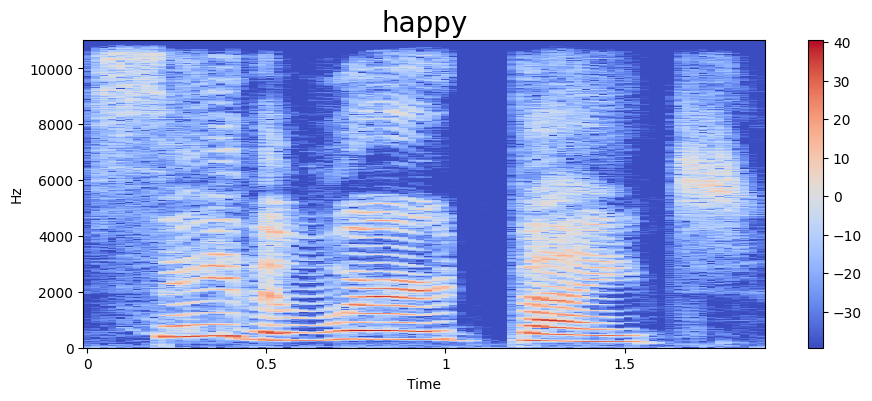

In [ ]:
emotion='happy'
path=np.array(df['audio_paths'][df['labels']==emotion])[0]
data, sampling_rate=librosa.load(path)
waveplot(data, sampling_rate,emotion)
spectogram(data, sampling_rate, emotion)
Audio(path)